## Unimodal Training before Multimodal Training

### Imports and class name extraction

In [1]:
import os, torch, torchvision, time, copy, timm
from skimage import transform
from __future__ import print_function, division
import torch.nn as nn, torch.optim as optim, matplotlib.pyplot as plt, numpy as np, pandas as pd, seaborn as sn
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms, utils 
from PIL import Image
from sklearn.metrics import confusion_matrix

device = 'cuda'
Vit = 1
ResNet50 = 1-Vit

def fast_scandir(dirname):
    subfolders= [f.path for f in os.scandir(dirname) if f.is_dir()]
    for dirname in list(subfolders):
        subfolders.extend(fast_scandir(dirname))
    return subfolders

classnames = fast_scandir('/kaggle/input/upmcfood101/images/test')
print('Number of classes: ',len(classnames))

print(classnames[0].split('/')[-1])
for iter1 in range(len(classnames)):
    classnames[iter1] = classnames[iter1].split('/')[-1]

classnames =  sorted(classnames)
print(classnames)
#index = classnames.index('grilled_cheese_sandwich')
#print(index)

Number of classes:  101
macarons
['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_a

### Dataset organization

In [2]:
image_root = '/kaggle/input/upmcfood101/images/'
datalink = {
    'train': '/kaggle/input/upmcfood101/texts/train_titles.csv',
    'test' : '/kaggle/input/upmcfood101/texts/test_titles.csv'
}

class MultimodalDataset(Dataset):
    # Modified from: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
    def __init__(self, csv_file, root_dir, transform = None, phase = None):
        self.csv_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.phase = phase

    def __len__(self):
        return len(self.csv_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sub_dirs = self.csv_frame.iloc[idx, 2] # here third column is the directory
        img_name = self.root_dir + self.phase +'/'+ sub_dirs +'/' + self.csv_frame.iloc[idx, 0] # here first column is the directory
        image = Image.open(img_name)
        labels = self.csv_frame.iloc[idx, 2]
        
        labels = classnames.index(labels)

        other_inputs = self.csv_frame.iloc[idx, 1] # Image caption at second column
        sample = {'image': image, 'information': other_inputs,'labels': labels}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample

### Dataloader and Augmentation

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((244,244)),
        transforms.RandomRotation(15,),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
}

class MM_transform(object):
    def __init__(self, phase):
        assert isinstance(phase,(str))
        self.phase = phase
        
    def __call__(self, sample):
        image, information, labels = sample['image'],sample['information'], sample['labels']
        trnsfrm = data_transforms[self.phase]
        image = trnsfrm(image)
        
        return {'image': image, 'information': information, 'labels': labels}

### Loading a batch

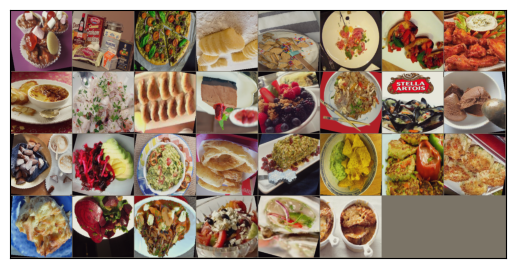

In [4]:
def dataset_phase(phase):
    return MultimodalDataset(csv_file = datalink[phase], root_dir = image_root,
                        transform = MM_transform(phase), phase=phase)

def dataloader_phase(phase):
    return DataLoader(dataset[phase], batch_size = 30+ResNet50*34,shuffle=True, num_workers=0)
    
dataset = {x: dataset_phase(x) for x in ['train', 'test']}
dataloaders = {x: dataloader_phase(x) for x in ['train', 'test']}
dataset_sizes = {x: len(dataset[x]) for x in ['train', 'test']}

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.yticks([])  
    plt.xticks([])  
    plt.imshow(inp)
    plt.savefig('Augmented_ultrasound.pdf', bbox_inches = 'tight') 
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
               
sample_batch = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(sample_batch['image'])
imshow(out)

### Model selection

In [5]:
Num_class = 101

if Vit:
    model_ft = timm.create_model('vit_large_patch16_224', pretrained=True, num_classes=Num_class)
    num_ftrs = model_ft.head.in_features
    model_ft.head = nn.Linear(num_ftrs, Num_class)

if ResNet50:
    model_ft = models.resnet50(pretrained=True)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, Num_class)

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

### Training function

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    test_token=0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for sample_batch in dataloaders[phase]:
                inputs = sample_batch['image'].to(device)
                labels = sample_batch['labels'].to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Training

In [7]:
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0005, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5) 

Epoch 0/4
----------
train Loss: 2.5186 Acc: 0.4194
test Loss: 1.5254 Acc: 0.6309

Epoch 1/4
----------
train Loss: 1.1864 Acc: 0.7102
test Loss: 1.1224 Acc: 0.7293

Epoch 2/4
----------
train Loss: 0.9205 Acc: 0.7709
test Loss: 1.0823 Acc: 0.7432

Epoch 3/4
----------
train Loss: 0.7249 Acc: 0.8157
test Loss: 1.0891 Acc: 0.7518

Epoch 4/4
----------
train Loss: 0.5516 Acc: 0.8530
test Loss: 1.1385 Acc: 0.7485

Training complete in 465m 30s
Best val Acc: 0.751838


### Save model

In [8]:
PATH = "./fine_tuned_model.pt"
torch.save(model_ft.state_dict(), PATH)

'''
#Guideline for loading model in future 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=False) 
        #We only need the structure to transfer parameters
        
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, Num_class)

model.load_state_dict(torch.load(PATH2, map_location=device))
'''

'\n#Guideline for loading model in future \ndevice = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")\nmodel = models.resnet50(pretrained=False) \n        #We only need the structure to transfer parameters\n        \nnum_ftrs = model.fc.in_features\nmodel.fc = nn.Linear(num_ftrs, Num_class)\n\nmodel.load_state_dict(torch.load(PATH2, map_location=device))\n'